In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
def trajectory_matrix(vector, L):
    K = len(vector) - L + 1
    for k in range(K):
        if k == 0:
            tr_m = vector[k:k + L].reshape(L, 1)
        else:
            tr_m = np.hstack((tr_m, vector[k:k + L].reshape(L, 1)))
    return(tr_m)

# Примеры рядов

In [4]:
series = pd.read_csv('./series1/difficultTrend_whiteNoise.csv')
series_noise = pd.read_csv('./series1/white_noise.csv')
series_trend = pd.read_csv('./series1/linear_trend.csv')
series_trend_noise = pd.read_csv('./series1/trend_whiteNoise.csv')
series_diff_trend = pd.read_csv('./series1/difficult_trend.csv')

## Броуновское движение

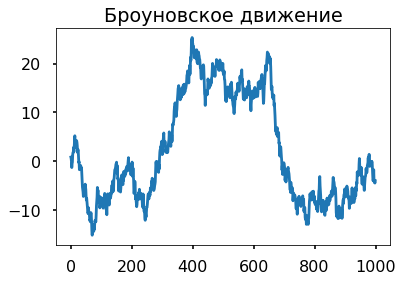

In [5]:
plt.plot(series_noise['series1'])
plt.title('Броуновское движение')
plt.show()

## Линейный тренд + боуновское движение

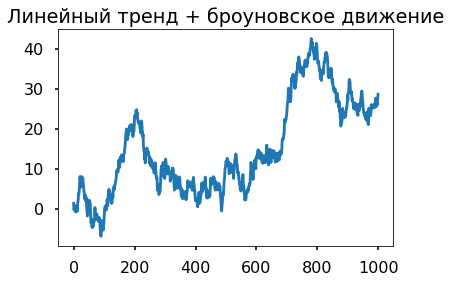

In [6]:
plt.plot(series_trend_noise['series3'])
plt.title('Линейный тренд + броуновское движение')
plt.show()

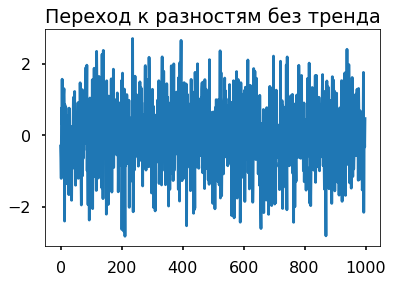

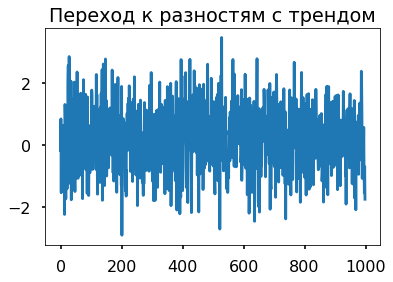

In [7]:
plt.plot(np.diff(series_noise['series1']))
plt.title('Переход к разностям без тренда')
plt.show()

plt.plot(np.diff(series_trend_noise['series1']))
plt.title('Переход к разностям с трендом')
plt.show()

Средние в рядах из разностей равны (для шума и для шума с трендом соответственно):

In [8]:
print(np.mean(np.diff(series_noise['series1'])), np.mean(np.diff(series_trend_noise['series1'])))

-0.0048396113542318025 0.24378246818350582


## Сложный тренд

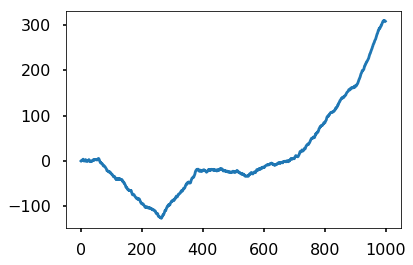

In [9]:
plt.plot(series['series1'])
plt.show()

# Линейная регрессия

## Линейный тренд

In [10]:
ts = series_trend['series2']

In [11]:
from sklearn import linear_model
from sklearn.utils import shuffle

In [12]:
def linear_regression(ts, k=2, l=300, fit_intercept=None, cv=None):
    ts_matrix_train = trajectory_matrix(np.array(ts), len(ts) - k)
    train_series = ts_matrix_train[:-l, :]
    test_series = ts_matrix_train[-l:, :]
    pred_train = train_series[:,-2:-1] + np.mean(np.diff(train_series[:,:-1])[:,-(k - 1):], axis=1).reshape(-1,1) 
    mse_train = mean_squared_error(pred_train, train_series[:, -1])
    pred_test = test_series[:,-2:-1] + np.mean(np.diff(test_series[:,:-1])[:,-(k - 1):], axis=1).reshape(-1,1) 
    mse_test = mean_squared_error(pred_test, test_series[:, -1])
    return [mse_train, mse_test, pred_test, test_series[:, -1]]

In [13]:
def linear_regression1(ts, k=1, fit_intercept=False, cv=None):
    ts_matrix_train = trajectory_matrix(np.array(ts), len(ts) - k)
    train_series = pd.DataFrame(ts_matrix_train[:-300, :])
    test_series = pd.DataFrame(ts_matrix_train[-300:, :])
    regr = linear_model.LinearRegression(fit_intercept=fit_intercept)
    regr.fit(train_series.iloc[:,:-1], train_series.iloc[:,-1])
    pred_train = regr.predict(train_series.iloc[:,:-1])
    mse_train = mean_squared_error(pred_train, train_series.iloc[:, -1])
    pred_test = regr.predict(test_series.iloc[:,:-1])
    mse_test = mean_squared_error(pred_test, test_series.iloc[:, -1])
    return [mse_train, mse_test, pred_test, test_series.iloc[:, -1]]

In [14]:
mse_train, mse_test, pred_test, series_test = linear_regression(ts)

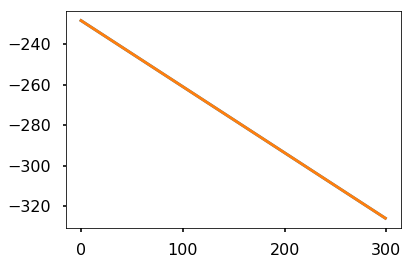

In [15]:
plt.plot(pred_test)
plt.plot(series_test)
plt.show()

In [16]:
def count_mean_mses_for_method(series_df, method=linear_regression, k=2):
    mses = []
    mses_train = []
    N = len(series_df.columns)
    for i in series_df.columns:
        ts = np.array(series_df[i])
        mse_train, mse_test, pred_test, series_test = method(ts, k=k)
        mses.append(mse_test)
        mses_train.append(mse_train)
    return [mses, mses_train]

mses, mses_train = count_mean_mses_for_method(series_trend)
print(np.mean(mses), '+/-', 2 * np.std(mses) / np.sqrt(len(series_trend)))  

3.3947571325189166e-27 +/- 2.6105659821506357e-28


## Линейный тренд + шум

In [17]:
ts = series_trend_noise['series3']

In [18]:
mse_train, mse_test, pred_test, series_test = linear_regression(ts, k=10)

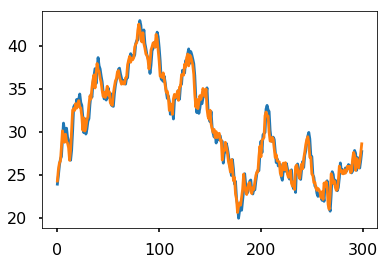

In [19]:
plt.plot(pred_test)
plt.plot(series_test)
plt.show()

In [20]:
mses, mses_train = count_mean_mses_for_method(series_trend_noise, k=10)
print(np.mean(mses), '+/-', 2 * np.std(mses) / np.sqrt(len(series_trend_noise)))  

1.120521418420927 +/- 0.006404884446983294


## Сложный тред

In [21]:
ts = series_diff_trend['series3']
mse_train, mse_test, pred_test, series_test = linear_regression(ts)

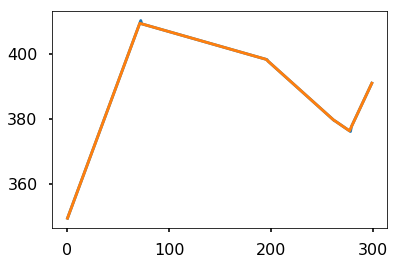

In [22]:
plt.plot(pred_test)
plt.plot(series_test)
plt.show()

In [23]:
mses, mses_train = count_mean_mses_for_method(series_diff_trend, linear_regression, k=10)
print(np.mean(mses), '+/-', 2 * np.std(mses) / np.sqrt(len(series_diff_trend)))  

0.007939896339953852 +/- 0.0008787836394295518


## Сложный тренд + шум

In [24]:
results = pd.DataFrame()

In [25]:
ts = series['series3']
mse_train, mse_test, pred_test, series_test = linear_regression(ts, k=10)

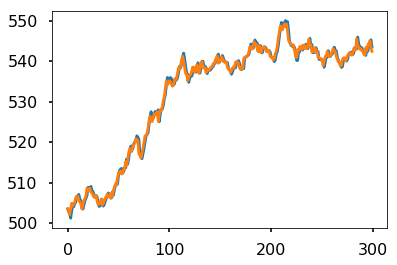

In [26]:
plt.plot(pred_test)
plt.plot(series_test)
plt.show()

In [27]:
mses, mses_train = count_mean_mses_for_method(series, k=10)
print(np.mean(mses), '+/-', 2 * np.std(mses) / np.sqrt(len(series)))  

1.1188379567265871 +/- 0.006680026830110617


## Выбор длины окна для регрессии

In [28]:
mse_train, mse_test, pred_test, series_test = linear_regression(series['series3'], k=10)

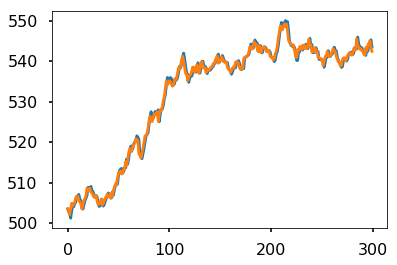

In [29]:
plt.plot(pred_test)
plt.plot(series_test)
plt.show()

In [30]:
def reg_choose_k(method, series, ks=list(range(2, 100, 1)),
                 fit_intercept=False, diff_flag=False, cv=5):
    mse = []
    mse_train_final = []
    k_choosen = []
    N = len(series.columns)
    for i in series.columns:
        ts = np.array(series[i])
        if diff_flag:
            ts = ts[1:] - ts[:-1]     
        mse_trains = {}
        mse_tests = {}
        for k in ks:
            mse_train, mse_test, pred_test, series_test = method(ts[:-300], k=k, 
                                                                 fit_intercept=fit_intercept, cv=cv)
            mse_trains[k] = mse_train
            mse_tests[k] = mse_test    
        best_k = list(mse_tests.keys())[list(mse_tests.values()).index(min(mse_tests.values()))]
        mse_train, mse_test, pred_test, series_test = method(ts, k=best_k, 
                                                             fit_intercept=fit_intercept, cv=cv)

        mse.append(mse_test)
        mse_train_final.append(mse_train)
        k_choosen.append(best_k)

    res = {'Mean test MSE': np.mean(mse),
           '+/- test': 2 * np.std(mse) / np.sqrt(N),
           'Mean train MSE': np.mean(mse_train_final),
           '+/- train': 2 * np.std(mse_train_final) / np.sqrt(N),
           'Mean number of variables': np.mean(k_choosen)}
    return res

In [31]:
def lasso_regressionCV(ts, k=1, fit_intercept=False, cv=3):
    ts_matrix_train = trajectory_matrix(np.array(ts), len(ts) - k)
    train_series = pd.DataFrame(ts_matrix_train[:-300, :])
    test_series = pd.DataFrame(ts_matrix_train[-300:, :])
    regr = linear_model.LassoCV(cv=cv, fit_intercept=fit_intercept, n_jobs=-1, tol=0.001)
    regr.fit(train_series.iloc[:,:-1], train_series.iloc[:,-1])
    pred_train = regr.predict(train_series.iloc[:,:-1])
    mse_train = mean_squared_error(pred_train, train_series.iloc[:, -1])
    pred_test = regr.predict(test_series.iloc[:,:-1])
    mse_test = mean_squared_error(pred_test, test_series.iloc[:, -1])
    return [mse_train, mse_test, pred_test, test_series.iloc[:, -1]]

In [32]:
def ridge_regressionCV(ts, k=1, fit_intercept=False, cv=3):
    ts_matrix_train = trajectory_matrix(np.array(ts), len(ts) - k)
    train_series = pd.DataFrame(ts_matrix_train[:-300, :])
    test_series = pd.DataFrame(ts_matrix_train[-300:, :])
    regr = linear_model.RidgeCV(cv=cv, fit_intercept=fit_intercept)
    regr.fit(train_series.iloc[:,:-1], train_series.iloc[:,-1])
    pred_train = regr.predict(train_series.iloc[:,:-1])
    mse_train = mean_squared_error(pred_train, train_series.iloc[:, -1])
    pred_test = regr.predict(test_series.iloc[:,:-1])
    mse_test = mean_squared_error(pred_test, test_series.iloc[:, -1])
    return [mse_train, mse_test, pred_test, test_series.iloc[:, -1]]

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import time

def svm_SVR(ts, k=1, flag=False, p=None):
    ts_matrix_train = trajectory_matrix(np.array(ts), len(ts) - k)
    train_series = pd.DataFrame(ts_matrix_train[:-300, :])
    test_series = pd.DataFrame(ts_matrix_train[-300:, :])
    
    if not flag:
        parameters = {'kernel':['linear'], 'C': [0.01, 0.05, 0.1]}
        svr = SVR()
        grid_searcher_svr = GridSearchCV(svr, parameters, n_jobs=-1, verbose=2)
        grid_searcher_svr.fit(train_series.iloc[:,:-1], train_series.iloc[:,-1])
    else:
        svr = SVR(**p)
        print(p)
        grid_searcher_svr = svr.fit(train_series.iloc[:,:-1], train_series.iloc[:,-1])

    pred_train = grid_searcher_svr.predict(train_series.iloc[:,:-1])
    mse_train = mean_squared_error(pred_train, train_series.iloc[:, -1])
    pred_test = grid_searcher_svr.predict(test_series.iloc[:,:-1])
    mse_test = mean_squared_error(pred_test, test_series.iloc[:, -1])
    if flag:
        return [mse_train, mse_test, pred_test, test_series.iloc[:, -1]]
    return [mse_train, mse_test, pred_test, test_series.iloc[:, -1], grid_searcher_svr.best_params_]

In [34]:
def svm_choose_k(method, series, ks=list(range(3, 100, 5)), diff_flag=False):
    mse = []
    mse_train_final = []
    k_choosen = []
    N = len(series.columns)
    for i in series.columns:
        # print(i)
        # time.sleep(10)
        ts = np.array(series[i])
        if diff_flag:
            ts = ts[1:] - ts[:-1]     
        mse_trains = {}
        mse_tests = {}
        p = {}
        for k in ks:
            mse_train, mse_test, pred_test, series_test, par = method(ts[:-300], k=k)
            mse_trains[k] = mse_train
            mse_tests[k] = mse_test    
            p[k] = par
        best_k = list(mse_tests.keys())[list(mse_tests.values()).index(min(mse_tests.values()))]
        mse_train, mse_test, pred_test, series_test = method(ts, k=best_k, flag=True, p=p[best_k])

        
        mse.append(mse_test)
        mse_train_final.append(mse_train)
        k_choosen.append(best_k)
        # print(mse, mse_train)
        
    res = {'Mean test MSE': np.mean(mse),
           '+/- test': 2 * np.std(mse) / np.sqrt(N),
           'Mean train MSE': np.mean(mse_train_final),
           '+/- train': 2 * np.std(mse_train_final) / np.sqrt(N),
           'Mean number of variables': np.mean(k_choosen)}
    return res

In [35]:
# dtrend = svm_choose_k(method=svm_SVR, series=series, diff_flag=True)

In [36]:
import time

def run_reg_for_series(series=series, svm=False):
    results = pd.DataFrame()
    # benchmark
    res = reg_choose_k(method=linear_regression, series=series)
    res['Method'] = 'Average diffs for trend estimation'
    results = results.append(res, ignore_index=True)
    
    # LR without intercept
    res = reg_choose_k(method=linear_regression1, series=series)
    res['Method'] = 'Basic LR without intercept'
    results = results.append(res, ignore_index=True)
    
    # LR with intercept
    res = reg_choose_k(method=linear_regression1, series=series, fit_intercept=True)
    res['Method'] = 'Basic LR with intercept'
    results = results.append(res, ignore_index=True)
    
    # LR without intercept on diffs
    res = reg_choose_k(method=linear_regression1, series=series, diff_flag=True,
                       ks = list(range(3, 100)))
    res['Method'] = 'Diff LR without intercept'
    results = results.append(res, ignore_index=True)
    
    # LR with intercept on diffs
    res = reg_choose_k(method=linear_regression1, series=series, diff_flag=True, fit_intercept=True,
                       ks = list(range(3, 100)))
    res['Method'] = 'Diff LR with intercept'
    results = results.append(res, ignore_index=True)
    
    time.sleep(60 * 5)
    
    # LASSO without intercept
    # res = reg_choose_k(method=lasso_regressionCV, series=series,
    #                   ks = list(range(2, 100, 5)))
    # res['Method'] = 'Basic LASSO without intercept'
    # results = results.append(res, ignore_index=True)
    
    # LASSO with intercept
    # res = reg_choose_k(method=lasso_regressionCV, series=series, fit_intercept=True,
    #                    ks = list(range(2, 100, 5)))
    # res['Method'] = 'Basic LASSO with intercept'
    # results = results.append(res, ignore_index=True)

    # LASSO without intercept on diffs
    res = reg_choose_k(method=lasso_regressionCV, series=series, diff_flag=True,
                        ks = list(range(3, 100, 5)))
    res['Method'] = 'Diff LASSO without intercept'
    results = results.append(res, ignore_index=True)
    
    # LASSO with intercept on diffs
    # res = reg_choose_k(method=lasso_regressionCV, series=series, fit_intercept=True, diff_flag=True,
    #                    ks = list(range(3, 100, 5)))
    # res['Method'] = 'Diff LASSO with intercept'
    # results = results.append(res, ignore_index=True)
    
    # RR without intercept
    # res = reg_choose_k(method=ridge_regressionCV, series=series, ks = list(range(2, 100, 5)))
    # res['Method'] = 'Basic RR without intercept'
    # results = results.append(res, ignore_index=True)
    
    # RR with intercept
    # res = reg_choose_k(method=ridge_regressionCV, series=series, fit_intercept=True, ks = list(range(2, 100, 5)))
    # res['Method'] = 'Basic RR with intercept'
    # results = results.append(res, ignore_index=True)

    # RR without intercept on diffs
    
    time.sleep(60 * 3)
    
    res = reg_choose_k(method=ridge_regressionCV, series=series, diff_flag=True, ks = list(range(3, 100, 5)))
    res['Method'] = 'Diff RR without intercept'
    results = results.append(res, ignore_index=True)
    
    # RR with intercept on diffs
    # res = reg_choose_k(method=ridge_regressionCV, series=series, fit_intercept=True, diff_flag=True,
    #                    ks = list(range(3, 100, 5)))
    # res['Method'] = 'Diff RR with intercept'
    # results = results.append(res, ignore_index=True)
    
    if not svm:
        return results
    
    time.sleep(60 * 5)
    
    # SVM 
    res = svm_choose_k(method=svm_SVR, series=series, diff_flag=True)
    res['Method'] = 'Diff SVM with linear kernel'
    results = results.append(res, ignore_index=True)
    
    return results

Так как (забегая вперёд), лучше всего себя показала регрессия на разностях без свбодного члена, то будем обучать аналогичные модели и на LASSO, RR (Ridge Regression) и SVM --- на разностях, без intercept (для регрессий).

### Результаты для шума

In [51]:
noise_res = run_reg_for_series(series_noise)

In [38]:
noise_res

,+/- test,+/- train,Mean number of variables,Mean test MSE,Mean train MSE,Method
0,0.018131,0.010878,78.58,1.024504,1.002072,Average diffs for trend estimation
1,0.019362,0.010419,6.20,1.031223,0.977444,Basic LR without intercept
2,0.021107,0.010486,6.59,1.044813,0.973410,Basic LR with intercept
3,0.019011,0.010592,6.24,1.022579,0.977928,Diff LR without intercept
4,0.019038,0.010473,6.39,1.024650,0.976409,Diff LR with intercept
5,0.018234,0.010349,39.55,1.013206,0.981953,Diff LASSO without intercept
6,0.018937,0.010464,5.70,1.020567,0.979879,Diff RR without intercept


### Результаты для линейного тренда

In [50]:
trend_res = run_reg_for_series(series_trend)

In [40]:
trend_res

,+/- test,+/- train,Mean number of variables,Mean test MSE,Mean train MSE,Method
0,3.025448e-28,6.966066e-29,24.18,1.295227e-27,2.844491e-28,Average diffs for trend estimation
1,4.680183e-27,1.042200e-27,51.25,1.188189e-26,2.720423e-27,Basic LR without intercept
2,1.672267e-27,4.319515e-28,40.44,4.576879e-27,1.078531e-27,Basic LR with intercept
3,1.672579e-28,3.386364e-29,37.67,7.479557e-28,1.328080e-28,Diff LR without intercept
4,1.340491e-28,2.959547e-29,23.66,5.989137e-28,1.132848e-28,Diff LR with intercept
5,1.586999e-08,1.586999e-08,42.60,6.045746e-08,6.045746e-08,Diff LASSO without intercept
6,4.813442e-09,4.813442e-09,98.00,4.609869e-09,4.609869e-09,Diff RR without intercept


### Результаты для линейного тренда + броуновского движения

In [49]:
trend_noise_res = run_reg_for_series(series_trend_noise)

In [42]:
trend_noise_res

,+/- test,+/- train,Mean number of variables,Mean test MSE,Mean train MSE,Method
0,0.017580,0.011598,78.57,1.024567,1.014398,Average diffs for trend estimation
1,0.021765,0.011333,15.78,1.065599,0.994755,Basic LR without intercept
2,0.022544,0.010813,5.63,1.036579,0.991068,Basic LR with intercept
3,0.018328,0.012468,12.32,1.063270,1.015876,Diff LR without intercept
4,0.018170,0.010699,5.65,1.019967,0.991274,Diff LR with intercept
5,0.018343,0.012202,53.65,1.047674,0.989926,Diff LASSO without intercept
6,0.018486,0.012740,12.90,1.062051,1.014656,Diff RR without intercept


### Результаты для сложного тренда

In [48]:
diff_trend_res = run_reg_for_series(series_diff_trend)

In [44]:
diff_trend_res

,+/- test,+/- train,Mean number of variables,Mean test MSE,Mean train MSE,Method
0,0.008061,0.002328,8.79,0.009491,0.006707,Average diffs for trend estimation
1,0.003852,0.000540,23.80,0.004926,0.002639,Basic LR without intercept
2,0.340725,0.000530,15.35,0.207792,0.002622,Basic LR with intercept
3,0.004364,0.000550,35.32,0.004705,0.002719,Diff LR without intercept
4,0.162600,0.000535,24.11,0.100636,0.002609,Diff LR with intercept
5,0.000881,0.000715,34.65,0.002567,0.003111,Diff LASSO without intercept
6,0.000938,0.000549,28.70,0.002711,0.002867,Diff RR without intercept


### Результаты для сложного тренда + броуновского движения

In [47]:
base_res = run_reg_for_series(series, svm=True)

In [46]:
base_res

,+/- test,+/- train,Mean number of variables,Mean test MSE,Mean train MSE,Method
0,0.021510,0.012922,51.04,1.070121,1.052186,Average diffs for trend estimation
1,0.035196,0.013825,20.84,1.151785,1.021539,Basic LR without intercept
2,0.070362,0.015527,15.63,1.262916,1.028862,Basic LR with intercept
3,0.020421,0.011836,15.84,1.088201,1.035141,Diff LR without intercept
4,0.039505,0.012553,14.88,1.144932,1.027051,Diff LR with intercept
5,0.020370,0.012886,41.90,1.087146,1.017852,Diff LASSO without intercept
6,0.020250,0.011610,15.80,1.086462,1.036206,Diff RR without intercept
7,0.039265,0.012616,22.00,1.149225,1.025665,Diff SVM with linear kernel
